Tensor("accuracy/Equal:0", shape=(1,), dtype=bool)
[ 59  43  50 ..., 140  84  72]
[6]
log(Loss): 0.0, accuracy: 0.1
log(Loss): 0.0, accuracy: 0.15
log(Loss): 0.0, accuracy: 0.15
log(Loss): 0.0, accuracy: 0.2
log(Loss): 0.0, accuracy: 0.15
log(Loss): 0.0, accuracy: 0.15
log(Loss): 0.0, accuracy: 0.15
log(Loss): 0.0, accuracy: 0.15
log(Loss): 0.0, accuracy: 0.15
log(Loss): 0.0, accuracy: 0.2


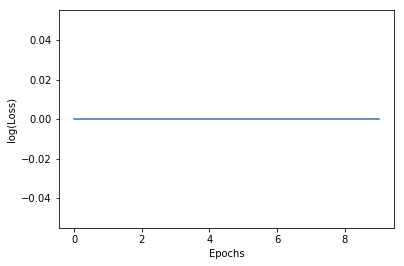

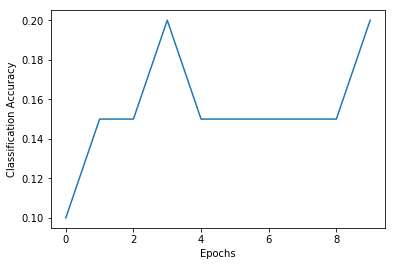

In [30]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from numpy import array, dot, random
from random import choice

tf.reset_default_graph()


x_in = tf.placeholder( tf.float32, None, name="x_in")
current_label = tf.placeholder(tf.int32, [1], name="current_label")
# logits  = tf.placeholder(tf.float32, None, name="logits")


def unpickle( file ):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def conv( x, filter_size=3, stride=2, num_filters=64, is_output=False, name="conv" ):
    channels = x.get_shape().as_list()[3];
    with tf.variable_scope(name) as scope:
        # Create a W filter variable wit the proper size
        W = tf.get_variable("W", None, dtype=tf.float32, initializer=tf.random_normal([filter_size, filter_size, channels, num_filters]))
        W = tf.Print(W, [W])
        result = W + 1
        # print tf.Print(W, [W])
        # Create a B bias varaible with the proper size
        B = tf.get_variable("B", None, dtype=tf.float32, initializer=tf.random_normal([num_filters]))
        # Convolve x with W by calling the tf.nn.conv2d function
        conv2d = tf.nn.conv2d(input=x,filter=W,strides=[1, stride, stride, 1],padding="SAME")
        # Add the bias
        # biased = conv2d + B;  #Does this work?
        biased = tf.nn.bias_add(conv2d, B)
        # If is_output is False
        if (is_output == False):
            # Call the tf.nn.relu function
            biased = tf.nn.relu(biased)
        # Return the final op
        return biased
    
def fc( x, out_size=50, is_output=False, name="fc" ):
    # Declare a name scope using the "name" parameter
    with tf.variable_scope(name) as scope:
        m = x.get_shape().as_list()[1];
        # Create a W filter variable with the proper size
        W = tf.get_variable("W", None, dtype=tf.float32, initializer=tf.random_normal([m, out_size]))
        # Create a B bias variable with the proper size
        B = tf.get_variable("B", None, dtype=tf.float32, initializer=tf.random_normal([1, out_size]))
        # Multiply x by W and add b
        mul_sum = tf.matmul(x, W) + B;
        # If is_output is False,
        if (is_output == False):
            #Call the tf.nn.relu function
            mul_sum = tf.nn.relu(mul_sum)
        #Return the final op
        return mul_sum
        

with tf.name_scope("nn") as scope:
    input_data_reshaped = tf.transpose(tf.reshape(x_in, [1, 3, 32, 32]), [0, 2, 3, 1])
    input_data_reshaped = tf.cast(input_data_reshaped, tf.float32)
    h0 = conv( input_data_reshaped, name="h0" )
    h1 = conv( h0, name="h1" )
    h2 = conv( h1, name="h2" )
    flat = tf.reshape(h2, [1, 1024])
    fc1 = fc(flat, name="fc1")
    my_logits = fc(fc1, out_size=10, is_output=True, name="my_logits");


# labels = tf.placeholder(tf.)
with tf.name_scope( "loss_function" ) as scope:
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=current_label, logits=my_logits)
    
with tf.name_scope( "accuracy" ) as scope:
    correct_prediction = tf.equal( tf.argmax(my_logits,1), tf.cast(current_label, tf.int64) )
    print correct_prediction
    maxarg = tf.argmax(my_logits, 1)
    accuracy = tf.reduce_mean( tf.cast(correct_prediction, tf.float32) )

train_step = tf.train.AdamOptimizer( 0.001 ).minimize( cross_entropy )



init = tf.global_variables_initializer() 
sess = tf.Session()
sess.run( init )
data = unpickle( 'cifar-10-batches-py/data_batch_1' )

features = data['data'] # 10000 x 3072
labels = data['labels']
labels = np.atleast_2d( labels ).T # 10000 x 1

print features[0]
print labels[0]


NUM_EPOCHS = 10
IMAGES = 100
TRAIN_CNT = (4 * IMAGES) / 5
TEST_CNT = IMAGES / 5

acc_results = np.array(np.zeros(NUM_EPOCHS))
loss_results = np.array(np.zeros(NUM_EPOCHS))

for i in range (0,NUM_EPOCHS):
    # Train on 80% of the data
    for j in range(0, TRAIN_CNT):
        sess.run(train_step, feed_dict={x_in: features[j], current_label: labels[j]})
    
    # Test on 20% of the data
    correct_cnt = 0.0
    for j in range(TRAIN_CNT, IMAGES):
        my_maxarg = sess.run([maxarg], feed_dict={x_in: features[j], current_label: labels[j]})
        if (my_maxarg[0] == labels[j]):
            correct_cnt = correct_cnt + 1
    acc = (1.0 * correct_cnt)/(TEST_CNT)
    xent = sess.run([cross_entropy], feed_dict={x_in: features[j], current_label: labels[j]})
    acc_results[i] = acc
    if (xent[0][0] != 0):
        xent[0][0] = np.log(xent[0][0])
    loss_results[i] = xent[0][0]
    print "log(Loss): " + str(xent[0][0]) + ", accuracy: " + str(acc)
       
    
writer = tf.summary.FileWriter("lab5", sess.graph)
writer.close()

plt.figure(1)
plt.plot(loss_results)
plt.xlabel("Epochs")
plt.ylabel("log(Loss)")


plt.figure(2)
plt.plot(acc_results)
plt.xlabel("Epochs")
plt.ylabel("Classification Accuracy")

plt.show()